# MS030 Preprocess
06/25/2023

In [5]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis/')

In [7]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [8]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS030'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [10]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [11]:
mne_data

<RawEDF | MS030_SWB.edf, 276 x 2505024 (2446.3 s), ~5.15 GB, data loaded>

In [14]:
mne_data.ch_names

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOPO1',
 'LmOPO2',
 'LmOPO3',
 'LmOPO4',
 'LmOPO5',
 'LmOPO6',
 'LmOPO7',
 'LmOPO8',
 'LmOPO9',
 'LCMmF1',
 'LCMmF2',
 'LCMmF3',
 'LCMmF4',
 'LCMmF5',
 'LCMmF6',
 'LCMmF7',
 'LCMmF8',
 'LCMmF9',
 'LCMmF10',
 'LCMmF11',
 'LCMmF12',
 'LCMmF13',
 'LCMmF14',
 'LCMmF15',
 'LCMmF16',
 'LsIPT1',
 'LsIPT2',
 'LsIPT3',
 'LsIPT4',
 'LsIPT5',
 'LsIPT6',
 'LsIPT7',
 'LsIPT8',
 'LpIPO1',
 'LpIPO2',
 'LpIPO3',
 'LpIPO4',
 'LpIPO5',
 'LpIPO6',
 'LpIPO7',
 'LpIPO8',
 'C64',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LHpIT11',
 'LHpIT12',
 'LpISM1',
 'LpISM2',
 'LpISM3',
 'LpISM4',
 'LpISM5',

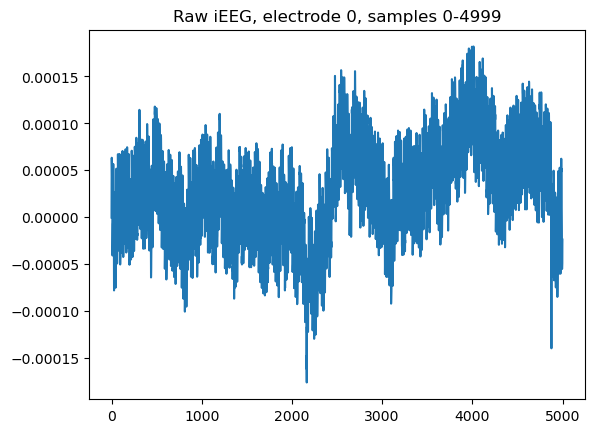

In [16]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

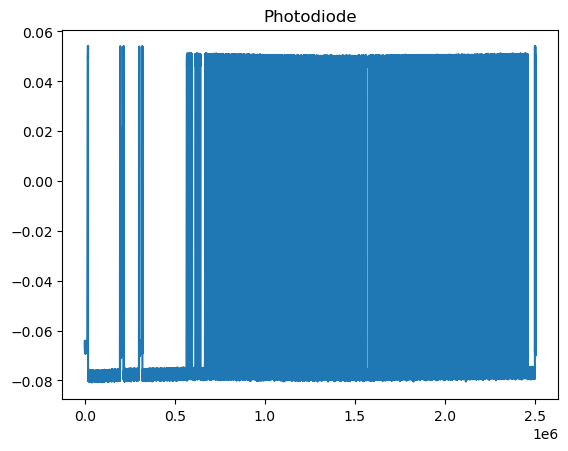

In [17]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


In [18]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination
0,LaCaS1,A32sg_L,-6.386112,38.974624,12.529659,-6.778861,29.725621,-10.464666,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus C,NaN
1,LaCaS2,A24rv_L,-6.386112,39.374364,17.322032,-6.875897,32.262463,-5.282710,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN
2,LaCaS3,A32sg_L,-6.386112,40.173843,22.513769,-6.814746,35.303751,0.166405,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN
3,LaCaS4,A32sg_L,-6.386112,40.573583,27.705506,-6.747162,37.927777,5.774297,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN
4,LaCaS5,A32p_L,-6.785244,41.373063,32.497879,-7.088346,40.719284,10.822374,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,LsIPT6,A44v_L,-50.689779,19.387377,25.708684,-53.847567,16.199871,12.962351,White,Left OpIFG opercular part of the inferior fron...,Area 44,L IFG (p Opercularis),L IFG,Left pars opercularis B,WM
128,LsIPT7,A44v_L,-55.080232,20.586596,26.507413,-58.757549,17.231126,13.255615,Gray,Left OpIFG opercular part of the inferior fron...,Area 44,L IFG (p Opercularis),L IFG,Left pars opercularis B,NaN
129,LsIPT8,Unknown,-59.869818,22.985034,28.104871,-64.018796,19.634418,13.941256,Unknown,Unknown,Area 45,Unknown,Unknown,Unknown,OOB
130,uLAgIt,mAmyg_L,-19.557472,16.988938,-11.032842,-20.656646,-1.544513,-27.097992,Gray,Left Ent entorhinal area,Amygdala (LB),L ParaHippocampal Gyrus,L Amyg,Left amygdala inferior,NaN


In [19]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LAgIt1',
 'LAgIt2',
 'LAgIt3',
 'LAgIt4',
 'LAgIt5',
 'LAgIt6',
 'LAgIt7',
 'LAgIt8',
 'LAgIt9',
 'LCMmF1',
 'LCMmF2',
 'LCMmF3',
 'LCMmF4',
 'LCMmF5',
 'LCMmF6',
 'LCMmF7',
 'LCMmF8',
 'LCMmF9',
 'LCMmF10',
 'LCMmF11',
 'LCMmF12',
 'LCMmF13',
 'LCMmF14',
 'LCMmF15',
 'LCMmF16',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LHpIT11',
 'LHpIT12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOPOrb1',
 'LmOPOrb2',
 'LmOPOrb3',
 'LmOPOrb4',
 'LmOPOrb5',
 'LmOPOrb6',
 'LmOPOrb7',
 'LmOPOrb8',
 'LmOPOrb9',
 'LpCAG1',
 'LpCAG2',
 'LpCAG3',
 'LpCAG4',
 'LpCAG5',
 'LpCAG6',
 'LpCAG7',
 'LpCAG8',
 'LpCAG9',
 'LpCAG10',
 'LpCAG11',
 'LpCAG12',
 'LpIPO1',
 'LpIPO2',
 'LpIPO3',
 'LpIPO4',
 'LpIPO5',
 'LpIPO6',
 'LpIPO7',
 'LpIPO8

In [20]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [21]:
unmatched_names

['ulagit', 'ulmoporb']

In [22]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [23]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [24]:
new_name_dict

{'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3',
 'LmCmS4': 'lmcms4',
 'LmCmS5': 'lmcms5',
 'LmCmS6': 'lmcms6',
 'LmCmS7': 'lmcms7',
 'LmCmS8': 'lmcms8',
 'LmCmS9': 'lmcms9',
 'LmCmS10': 'lmcms10',
 'LmOPO1': 'lmoporb1',
 'LmOPO2': 'lmoporb2',
 'LmOPO3': 'lmoporb3',
 'LmOPO4': 'lmoporb4',
 'LmOPO5': 'lmoporb5',
 'LmOPO6': 'lmoporb6',
 'LmOPO7': 'lmoporb7',
 'LmOPO8': 'lmoporb8',
 'LmOPO9': 'lmoporb9',
 'LCMmF1': 'lcmmf1',
 'LCMmF2': 'lcmmf2',
 'LCMmF3': 'lcmmf3',
 'LCMmF4': 'lcmmf4',
 'LCMmF5': 'lcmmf5',
 'LCMmF6': 'lcmmf6',
 'LCMmF7': 'lcmmf7',
 'LCMmF8': 'lcmmf8',
 'LCMmF9': 'lcmmf9',
 'LCMmF10': 'lcmmf10',
 'LCMmF11': 'lcmmf11',
 'LCMmF12': 'lcmmf12',
 'LCMmF13': 'lcmmf13',
 'LCMmF14': 'lcmmf14',
 'LCMmF15': 'lcmmf1

In [25]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS030_SWB.edf, 276 x 2505024 (2446.3 s), ~5.15 GB, data loaded>

In [26]:
unmatched_seeg

[]

In [27]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c64', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'dc', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'd

In [28]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 130 left & 0 right sEEG electrodes
We have a total of 130 sEEG electrodes


In [29]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c128',
 'c211',
 'c180',
 'c240',
 'c237',
 'ekg2',
 'c167',
 'c251',
 'c196',
 'dc5',
 'c209',
 'c227',
 'trig',
 'c205',
 'c239',
 'dc15',
 'c183',
 'c230',
 'c238',
 'c215',
 'c218',
 'c221',
 'p3',
 'c64',
 'c123',
 'c171',
 'dc14',
 'c179',
 'c181',
 'c173',
 'c201',
 'dc16',
 'c206',
 'dc3',
 't3',
 'c190',
 'c244',
 'c255',
 'dc2',
 'c125',
 'c121',
 'c191',
 't6',
 'c252',
 'c127',
 'c166',
 'c188',
 'dc',
 'c189',
 'c228',
 'c163',
 'c200',
 'c225',
 'dc7',
 'c226',
 'c212',
 'c178',
 'c245',
 'dc12',
 'c198',
 'c213',
 'c232',
 'dc6',
 'dc8',
 'f3',
 'c126',
 'c184',
 'osat',
 't5',
 'o1',
 't4',
 'c233',
 'c256',
 'c208',
 'c195',
 'c182',
 'c216',
 'c250',
 'f7',
 'c248',
 'p4',
 'dc4',
 'o2',
 'dc10',
 'c194',
 'c231',
 'ekg1',
 'c185',
 'c235',
 'c3',
 'c204',
 'c165',
 'f8',
 'dc13',
 'c222',
 'c219',
 'pz',
 'c197',
 'cz',
 'c170',
 'dc9',
 'c242',
 'c254',
 'fp2',
 'c120',
 'c187',
 'dc11',
 'c4',
 'c192',
 'c253',
 'f4',
 'c124',
 'c164',
 'c175',
 'c186',
 'c193',


In [30]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS030_SWB.edf, 131 x 2505024 (2446.3 s), ~2.45 GB, data loaded>

In [31]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS030_SWB.edf, 131 x 2505024 (2446.3 s), ~2.45 GB, data loaded>

In [32]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS030_SWB.edf, 131 x 2505024 (2446.3 s), ~2.45 GB, data loaded>

### Notch filter line noise

In [33]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    8.0s finished


<RawEDF | MS030_SWB.edf, 131 x 2505024 (2446.3 s), ~2.45 GB, data loaded>

### Resampling Data

In [34]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    9.6s finished


<RawEDF | MS030_SWB.edf, 131 x 1252512 (2446.3 s), ~1.22 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [35]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [36]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [37]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['lhpit3', 'lpipo8', 'lprecusp5', 'lsipt6', 'lsipt7', 'lsipt8']

In [38]:
mne_data.info['bads'] = bads

In [39]:
mne_data.info

<Info | 10 non-empty values
 bads: 6 items (lhpit3, lpipo8, lprecusp5, lsipt6, lsipt7, lsipt8)
 ch_names: lacas1, lacas2, lacas3, lacas4, lacas5, lacas6, lacas7, lacas8, ...
 chs: 130 sEEG
 custom_ref_applied: False
 dig: 130 items (130 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 15:14:59 UTC
 nchan: 130
 projs: []
 sfreq: 512.0 Hz
>

In [40]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [41]:
probe_names

array(['lacas', 'lagit', 'lcmmf', 'lhpit', 'lmcms', 'lmoporb', 'lpcag',
       'lpipo', 'lpism', 'lprecuoc', 'lprecusp', 'lsipt', 'ulagit',
       'ulmoporb'], dtype='<U8')

In [42]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [43]:
probe_ch_counts

{'lacas': 12,
 'lagit': 9,
 'lcmmf': 16,
 'lhpit': 12,
 'lmcms': 10,
 'lmoporb': 9,
 'lpcag': 12,
 'lpipo': 8,
 'lpism': 10,
 'lprecuoc': 12,
 'lprecusp': 12,
 'lsipt': 8,
 'ulagit': 1,
 'ulmoporb': 1}

<IPython.core.display.Javascript object>


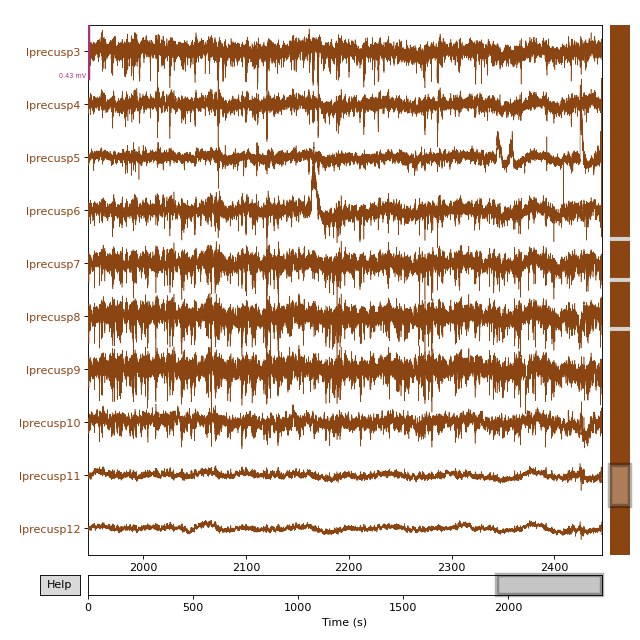

<IPython.core.display.Javascript object>


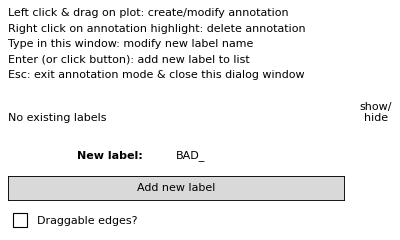

In [47]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/50)
fig.fake_keypress('a')

In [48]:
mne_data.info['bads']

['lhpit3', 'lprecusp5', 'lsipt6']

In [49]:
#set bad channel info 
bad_ch = ['lhpit3', 'lprecusp5', 'lsipt6']



In [50]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = bad_ch 

In [51]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 3 items (lhpit3, lprecusp5, lsipt6)
 ch_names: lacas1, lacas2, lacas3, lacas4, lacas5, lacas6, lacas7, lacas8, ...
 chs: 130 sEEG
 custom_ref_applied: False
 dig: 130 items (130 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 15:14:59 UTC
 nchan: 130
 projs: []
 sfreq: 512.0 Hz
>

### Rereference data to wm electrodes

In [52]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [53]:
oob_channels

['lacas11',
 'lacas12',
 'lcmmf15',
 'lcmmf16',
 'lhpit12',
 'lmcms9',
 'lmcms10',
 'lpism9',
 'lpism10',
 'lprecuoc11',
 'lprecuoc12',
 'lprecusp12',
 'lsipt8']

In [54]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [55]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas11',
 'lacas12',
 'lcmmf15',
 'lcmmf16',
 'lhpit12',
 'lhpit3',
 'lmcms10',
 'lmcms9',
 'lpism10',
 'lpism9',
 'lprecuoc11',
 'lprecuoc12',
 'lprecusp12',
 'lprecusp5',
 'lsipt6',
 'lsipt8']

In [56]:
mne_data.save(f'{neural_dir}{subj_id}/lfp_data.fif',overwrite=True)

In [57]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [58]:
mne_data_reref

<RawEDF | MS030_SWB.edf, 99 x 1252512 (2446.3 s), ~946.2 MB, data loaded>

In [59]:
mne_data_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)